# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [13]:
# Nothing To Do

### Imports


In [14]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [15]:
files = os.listdir(os.curdir + "/files")
parquet_files = []
for file in files:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
        parquet_files.append(file)

In [16]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    if parts[1] == "dataset":
        dataset = parts[0]
        method = parts[2]
        fold = parts[-1]
    elif parts[2] == "dataset":
        dataset = parts[0] + parts[1]
        method = parts[3]
        fold = parts[-1]
    elif parts[3] == "dataset":
        dataset = parts[0] + parts[1] + parts[2]
        method = parts[4]
        fold = parts[-1]
    if method == "xxx":
        print("xxx is not a valid method name")
    else:
        df = pd.read_parquet("files/" + file)
        
            
        df = df[df['status'] == 'success']
        try:
            metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
            value = np.average(metric_accuracy)
            df_all = df_all._append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
        except KeyError as e:
            print(str(e) + " for file " + str(file))

'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_lgbm_classifier_pipeline_1.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_lgbm_classifier_pipeline_1.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_0.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_0.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_openfe_lgbm_classifier_pipeline_lgbm_lgbm_3.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_openfe_lgbm_classifier_pipeline_lgbm_lgbm_3.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_9.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_9.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximi

In [17]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

              Dataset              Method     Value
0             abalone            autofeat  0.813284
1             abalone           autogluon  0.959551
2             abalone              boruta  0.884397
3             abalone  correlationBasedFS  0.871825
4             abalone               mljar  0.906537
..                ...                 ...       ...
115  winequalitywhite           bioautoml  0.796000
116  winequalitywhite  correlationBasedFS  0.898586
117  winequalitywhite                 h2o  0.953069
118  winequalitywhite               mljar  0.886400
119  winequalitywhite            original  0.806756

[120 rows x 3 columns]


In [18]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

              Dataset              Method     Value    StdDev  \
0             abalone            autofeat  0.813284  0.093089   
1             abalone           autogluon  0.959551  0.052766   
2             abalone              boruta  0.884397  0.046658   
3             abalone  correlationBasedFS  0.871825  0.062477   
4             abalone               mljar  0.906537  0.026368   
..                ...                 ...       ...       ...   
115  winequalitywhite           bioautoml  0.796000  0.103880   
116  winequalitywhite  correlationBasedFS  0.898586  0.131950   
117  winequalitywhite                 h2o  0.953069  0.033817   
118  winequalitywhite               mljar  0.886400  0.119438   
119  winequalitywhite            original  0.806756  0.094919   

                             Value_with_StdDev  
0     0.8132843117909951 ± 0.09308910011081249  
1    0.9595507253818492 ± 0.052766378112794075  
2     0.8843966152940874 ± 0.04665793176279741  
3    0.8718249558849116

In [19]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+----+------------------------+---------------------------------------------+-------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
|    |        Dataset         |                  autofeat                   |                 autogluon                 |                 bioautoml                 |                   boruta                   |            correlationBasedFS             |                    h2o                    |                   mljar                   |                  openfe                   |                 original                  |
+----+------------------------+---------------------------------------------+-------------------------------------------+-----------------

### Boxplots

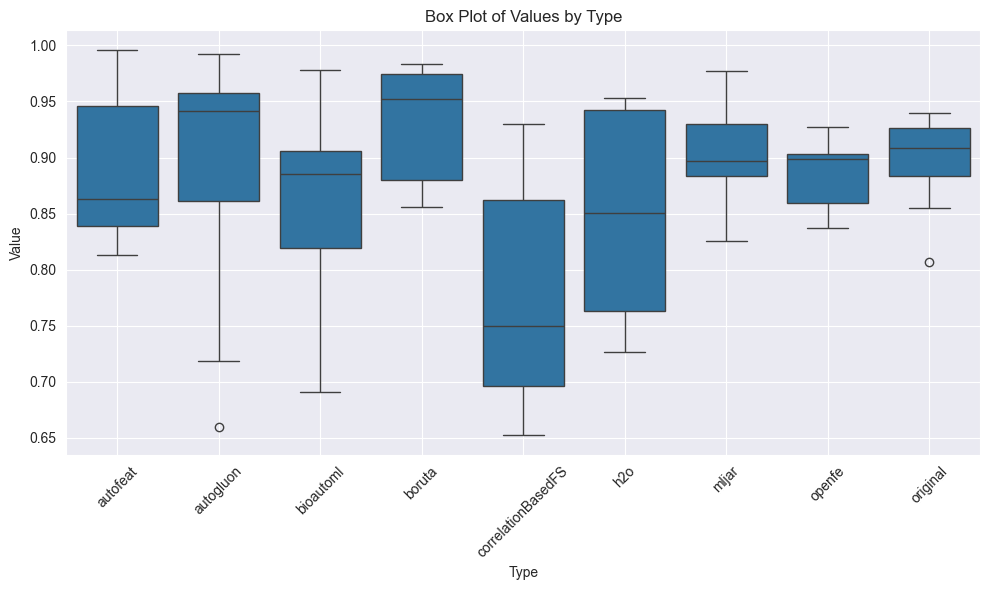

In [20]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()